# Практическое задание №6 по теме "Сегментация".

<ol>
    <li>Попробуйте обучить нейронную сеть U-Net на любом другом датасете.
    </li>
    <li>*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview</li>
    <li>*Сделайте свою реализацию U-Net на TensorFlow</li>
</ol>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [3]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (256, 256))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (256, 256))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

## Загрузка данных

In [5]:
dataset, info = tfds.load('caltech_birds2011:0.*.*', with_info=True)

Датасет уже содержит необходимые тестовый и тренеровочный сплиты.

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Построим модель нейроннной сети

In [9]:
OUTPUT_CHANNELS = 3

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [11]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [12]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='SGD',
              loss=tf.keras.losses.KLDivergence(),
              metrics=['top_k_categorical_accuracy'])

Обучим нейронную сеть на GPU

In [14]:
EPOCHS = 15 
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
if tf.config.list_physical_devices("GPU"):
    with tf.device("GPU:0"):
        model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/15
187/187 [==============================] - 52s 233ms/step - loss: 0.0240 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3936e-05 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/15
187/187 [==============================] - 43s 227ms/step - loss: 1.4294e-05 - top_k_categorical_accuracy: 1.0000 - val_loss: -5.1255e-05 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/15
187/187 [==============================] - 42s 227ms/step - loss: -6.1234e-05 - top_k_categorical_accuracy: 1.0000 - val_loss: -8.2678e-05 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/15
187/187 [==============================] - 43s 228ms/step - loss: -9.1084e-05 - top_k_categorical_accuracy: 1.0000 - val_loss: -1.0054e-04 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/15
187/187 [==============================] - 43s 228ms/step - loss: -1.0702e-04 - top_k_categorical_accuracy: 1.0000 - val_loss: -1.1187e-04 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/15
187/187 [==============================] 

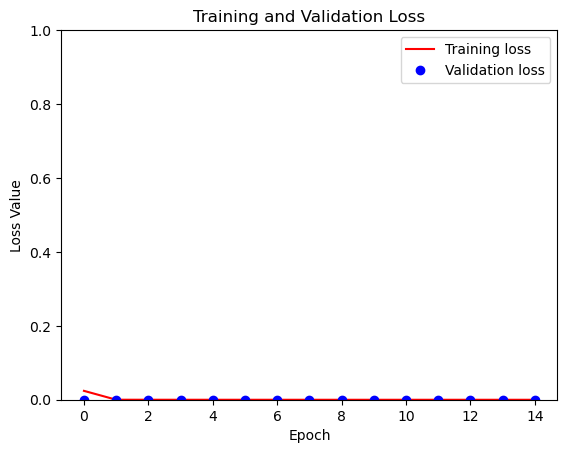

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Предсказание

In [119]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [128]:
def display(dataset=None, num=1):
    plt.figure(figsize=(12, 48))
    plt.subplots_adjust(wspace=0.2, hspace=0.1)
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    k=0
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display_list = [image[0], mask[0], create_mask(pred_mask)]
        for i in range(len(display_list)):
            plt.subplot(num, len(display_list), k+i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        k+=3
#         plt.show()

1/1 [==============================] - 0s 31ms/step


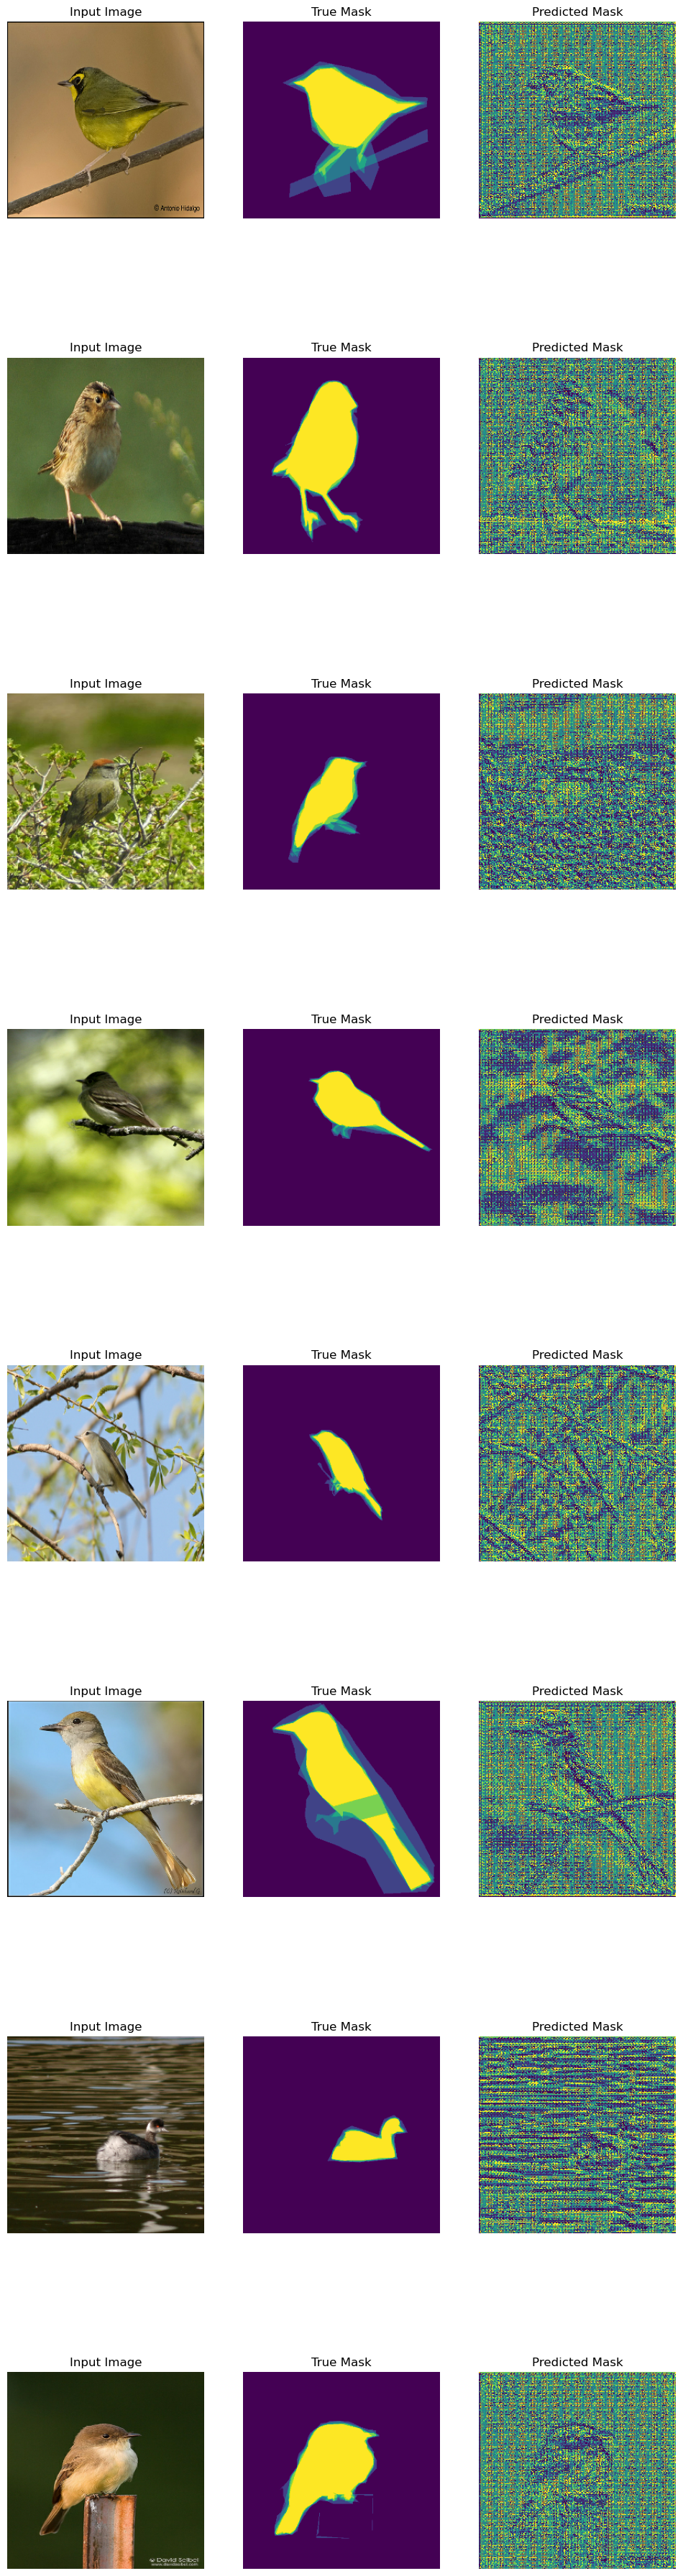

In [129]:
display(test_dataset, 8)

Как видно из полученных предсказаний, при обучении на 15-ти эпохах модель довольно неплохо произвела сегментацию изображений птиц.

---

---